In [1]:
# lstm autoencoder predict sequence
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.utils import plot_model
import matplotlib.pyplot as plt
# Reference: https://scikit-learn.org/stable/modules/clustering.html#clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import datasets, metrics
import seaborn as sns

Using TensorFlow backend.


Define a function to convert Pandas DataFrame outputted from `satellite_imagery(..., plot_option='no')` to numpy array

In [2]:
def time_series_prep(in_df, stat_option):
    col_lst = list(in_df.columns)
    col_lst_select = [i for i in col_lst if stat_option in i]
    # Rearrange the order the columns based on YYYYMM
    col_lst_select.sort()
    out_df = in_df[col_lst_select]
    return out_df.to_numpy()

Define a function to perform K-means classification

In [3]:
def kmeans(org_arr, in_arr, n_classes):
    # Reference: https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51
    model = KMeans(n_clusters=n_classes)
    model.fit(in_arr)
    model.predict(in_arr)
    labels = model.labels_
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    print('Silhouette Coefficient is: ', metrics.silhouette_score(org_arr, labels, metric='euclidean'))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("K Means", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform Agglomerative Clustering

In [4]:
def agglomerative(org_arr, in_arr, n_classes):
    # Reference: https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51
    model = AgglomerativeClustering(n_clusters=n_classes)
    model.fit(in_arr)
    labels = model.labels_
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    print('Silhouette Coefficient is: ', metrics.silhouette_score(org_arr, labels, metric='euclidean'))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("Agglomerative Clustering", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform Gaussian Mixture Clustering  
(Neither GaussianMixture or BayesianGaussianMixture performed well on either Idaho or Indian data)

In [5]:
# Reference: https://machinelearningmastery.com/clustering-algorithms-with-python/
def gaussian(org_arr, in_arr, n_classes):
    model = GaussianMixture(n_components=n_classes)
    model = BayesianGaussianMixture(n_components=n_classes)
    model.fit(in_arr)
    labels = model.predict(in_arr)
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    print('Silhouette Coefficient is: ', metrics.silhouette_score(org_arr, labels, metric='euclidean'))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("Agglomerative Clustering", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform LSTM encode and decode actions

In [6]:
def LSTM_autoencoder(in_arr, n_features, n_epochs):
    # Reference: https://machinelearningmastery.com/lstm-autoencoders/
    # reshape input into [samples, timesteps, features] if needed
    sequence = in_arr.reshape((in_arr.shape[0], in_arr.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_features, activation='relu', input_shape=(in_arr.shape[1],1)))
    model.add(RepeatVector(in_arr.shape[1]))
    model.add(LSTM(n_features, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    # fit model
    history = model.fit(sequence, sequence, validation_split = 0.5, epochs=n_epochs)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    # plt.title('model accuracy')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    
    # connect the encoder LSTM as the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[0].output)
    # get the feature vector for the input sequence
    yhat = model.predict(sequence)
    return yhat

In [7]:
def LSTM_autoencoder_plus(in_arr, n_features, n_epochs):
    check = 0
    while (check == 0):
        yhat = LSTM_autoencoder(in_arr, n_features, n_epochs)
        nrows = in_arr.shape[0]
        check = 1
        for col in range(n_features):
            n_zeros = (yhat[:,col]==0).sum()
            print('Column {} has {:.2%} of zeros'.format(col, n_zeros/nrows))
            if n_zeros == nrows:
                check = 0
        if check == 0:
            print('At least 1 column is all zeros. Refit -------------------------------------------')
    return yhat

Read in data output from `GEE_SatelliteImagery_EDA.ipynb`

In [8]:
ID_df = pd.read_csv('time_series_ID_scale10.csv')
ID_df.head()

Unnamed: 0        lat         lon  201805_NDVI  201805_SAVI  201805_EVI  \
0           0  43.768661 -116.739350     0.176445     0.264642    0.561106   
1           1  43.768661 -116.739260     0.172219     0.258304    0.530505   
2           2  43.768661 -116.739170     0.166754     0.250107    0.514179   
3           3  43.768661 -116.739081     0.165201     0.247778    0.498756   
4           4  43.768661 -116.738991     0.165201     0.247778    0.498756   

   201812_NDVI  201812_SAVI  201812_EVI  201801_NDVI  ...  201810_EVI  \
0     0.110320     0.165463    1.181932    -0.014664  ...    2.157721   
1     0.100356     0.150518    1.080581    -0.018005  ...    2.201001   
2     0.088017     0.132011    1.120817    -0.022291  ...    2.114196   
3     0.108057     0.162068    1.569025    -0.022249  ...    1.722504   
4     0.108057     0.162068    1.569025    -0.022249  ...    1.722504   

   201808_NDVI  201808_SAVI  201808_EVI  201809_NDVI  201809_SAVI  201809_EVI  \
0     0.664816     0.997105   -7.735765     0.714488     1.071605   12.477374   
1     0.665370     0.997933  -18.304278     0.692162     1.038121   11.431691   
2     0.660143     0.990098  -19.423686     0.702319     1.053354   10.833210   
3     0.658597     0.987778   -6.962047     0.704748     1.056998   12.353717   
4     0.658597     0.987778   -6.962047     0.704748     1.056998   12.353717   

   201807_NDVI  201807_SAVI  201807_EVI  
0     0.653170     0.979619   -3.501948  
1     0.662800     0.994062   -2.991320  
2     0.647084     0.970498   -2.342274  
3     0.615602     0.923282   -4.086213  
4     0.615602     0.923282   -4.086213  

[5 rows x 36 columns]

In [9]:
ID_arr = time_series_prep(in_df=ID_df, stat_option='NDVI')

Model 1: K-Means

Silhouette Coefficient is:  0.8010584381221377


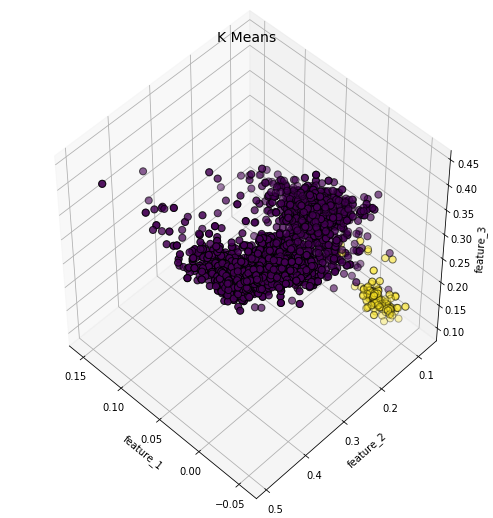

In [10]:
ID_label = kmeans(org_arr=ID_arr, in_arr=ID_arr, n_classes=2)

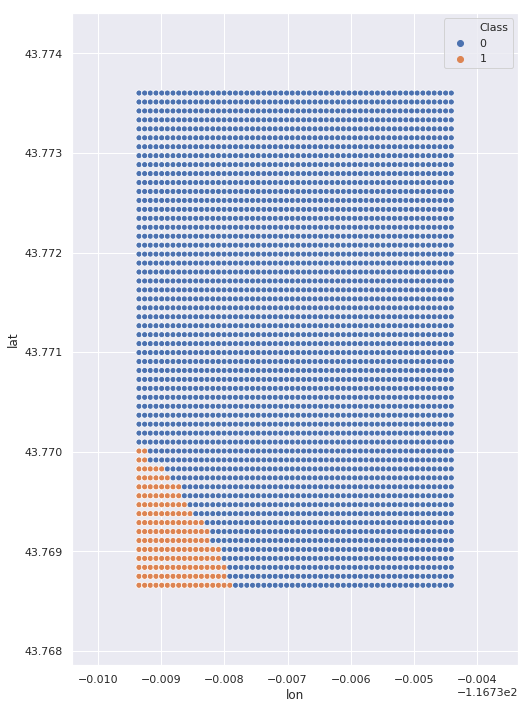

In [11]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 2: Agglomerative Clustering

Silhouette Coefficient is:  0.796961363954133


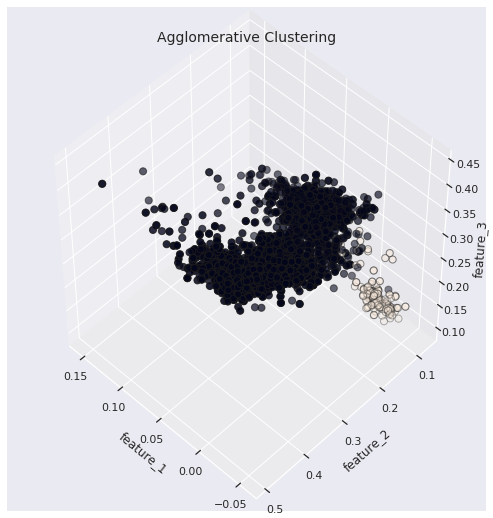

In [12]:
ID_label = agglomerative(org_arr=ID_arr, in_arr=ID_arr, n_classes=2)

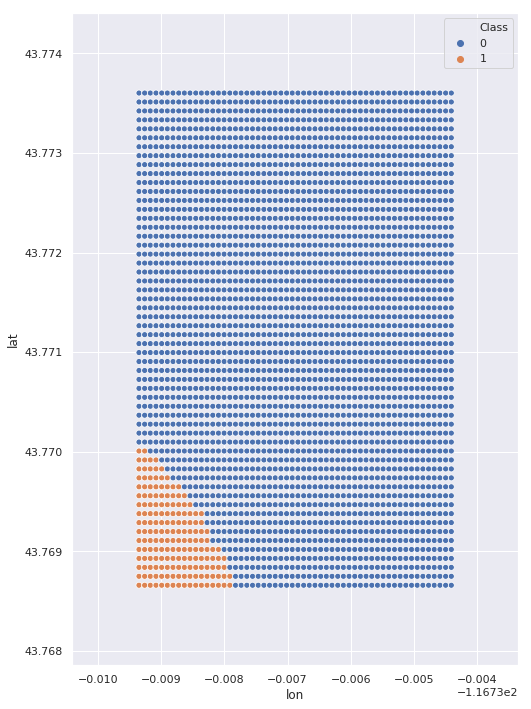

In [13]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 3: LSTM Autoencoder + K-Means

Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 1s 718us/step - loss: 0.1829 - val_loss: 0.1302
Epoch 2/50
1568/1568 [==============================] - 1s 324us/step - loss: 0.1094 - val_loss: 0.0777
Epoch 3/50
1568/1568 [==============================] - 0s 300us/step - loss: 0.0895 - val_loss: 0.0754
Epoch 4/50
1568/1568 [==============================] - 0s 288us/step - loss: 0.0876 - val_loss: 0.0741
Epoch 5/50
1568/1568 [==============================] - 0s 292us/step - loss: 0.0864 - val_loss: 0.0732
Epoch 6/50
1568/1568 [==============================] - 0s 297us/step - loss: 0.0856 - val_loss: 0.0727
Epoch 7/50
1568/1568 [==============================] - 0s 315us/step - loss: 0.0850 - val_loss: 0.0721
Epoch 8/50
1568/1568 [==============================] - 1s 326us/step - loss: 0.0846 - val_loss: 0.0717
Epoch 9/50
1568/1568 [==============================] - 0s 301us/step - loss: 0.0843 - val_loss: 0.0714
Epoch 10/50
1568

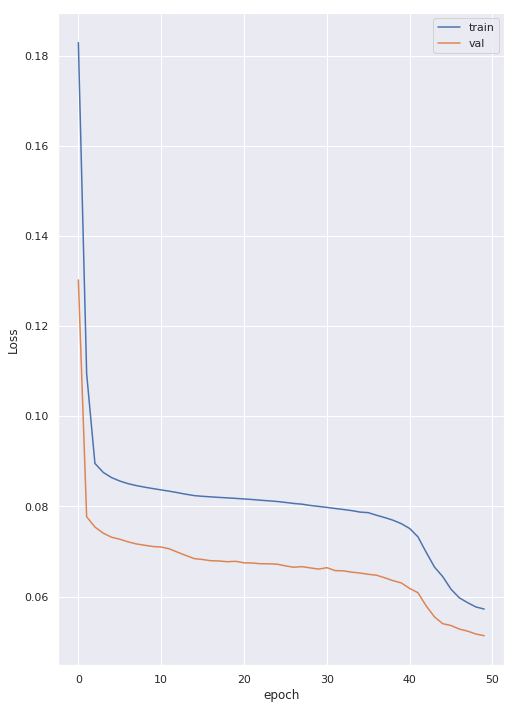

Column 0 has 0.00% of zeros
Column 1 has 0.00% of zeros
Column 2 has 0.00% of zeros


In [14]:
ID_feature = LSTM_autoencoder_plus(in_arr=ID_arr, n_features=3, n_epochs=50)

Silhouette Coefficient is:  0.7911864323822356


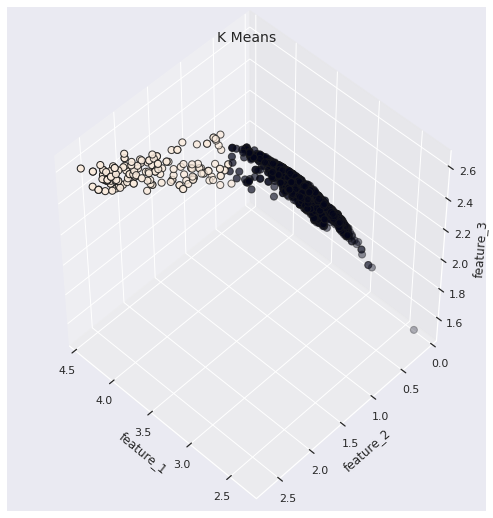

In [15]:
ID_label = kmeans(org_arr=ID_arr, in_arr=ID_feature, n_classes=2)

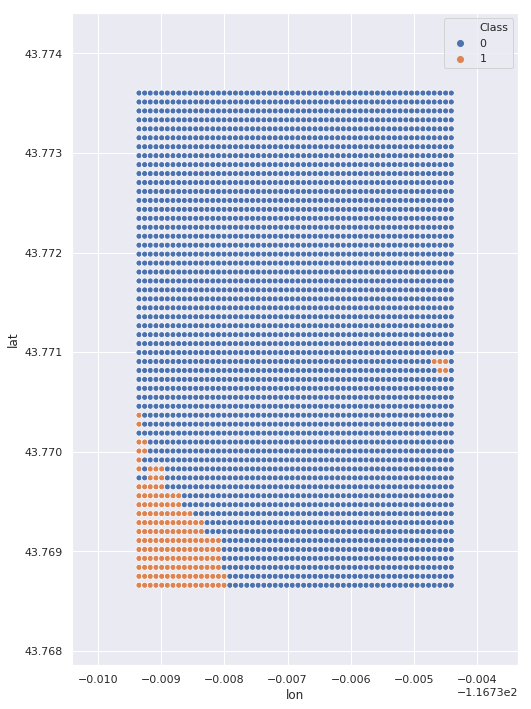

In [16]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 4: LSTM Autoencoder + Agglomerative Clustering

Silhouette Coefficient is:  0.7872749062926678


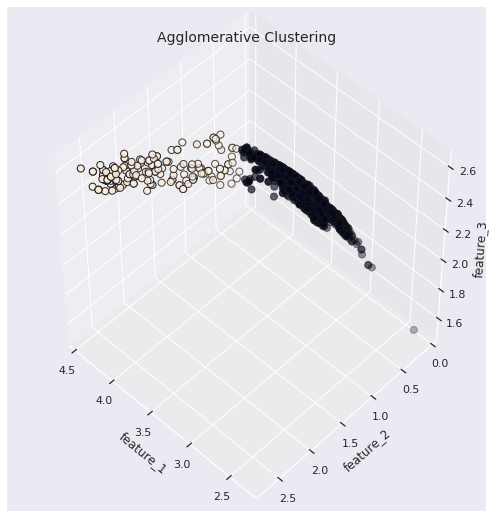

In [17]:
ID_label = agglomerative(org_arr=ID_arr, in_arr=ID_feature, n_classes=2)

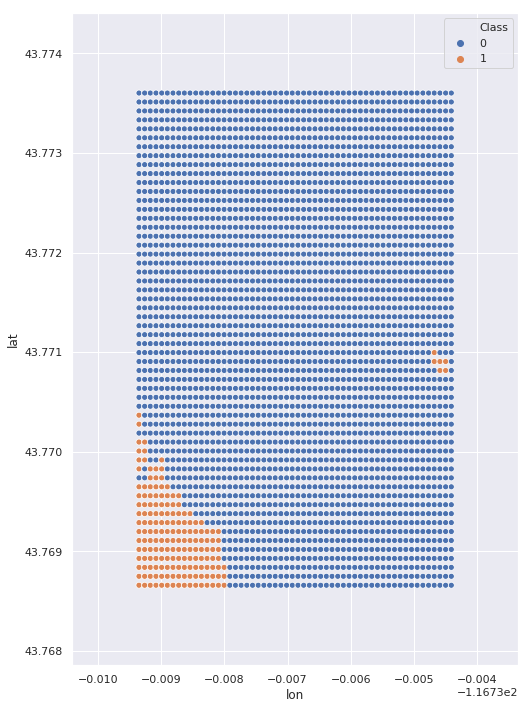

In [18]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

===========================================================================================================

Model 1: K-Means

In [19]:
ID_df = pd.read_csv('time_series_India_scale10.csv')
ID_arr = time_series_prep(in_df=ID_df, stat_option='NDVI')

Silhouette Coefficient is:  0.32345999373594436


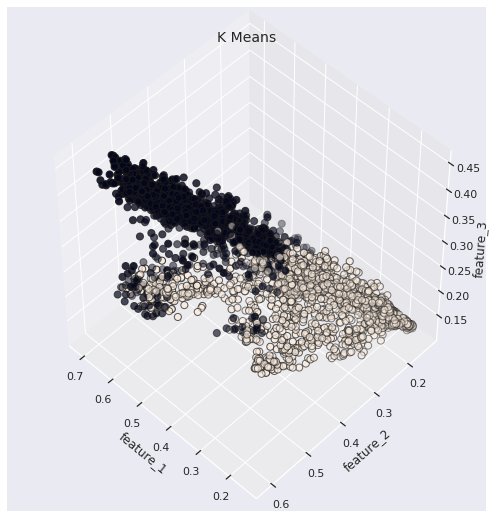

In [20]:
ID_label = kmeans(org_arr=ID_arr, in_arr=ID_arr, n_classes=2)

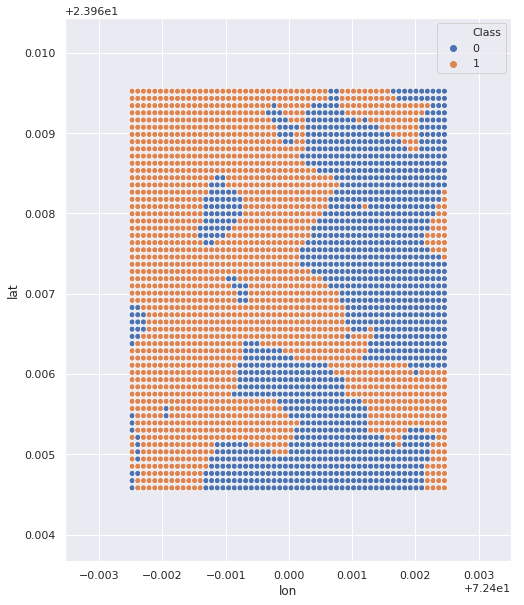

In [21]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,10)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 2: Agglomerative Clustering

Silhouette Coefficient is:  0.3066571400999005


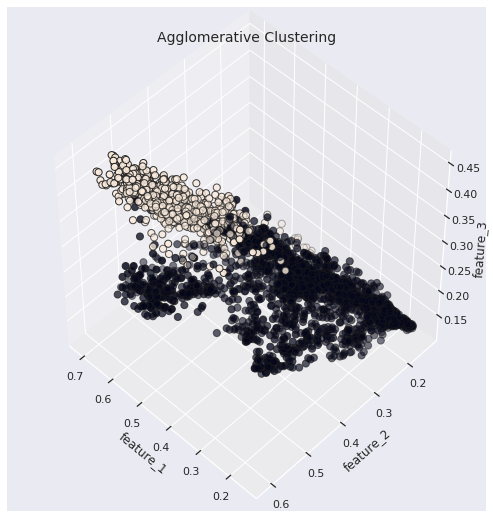

In [22]:
ID_label = agglomerative(org_arr=ID_arr, in_arr=ID_arr, n_classes=2)

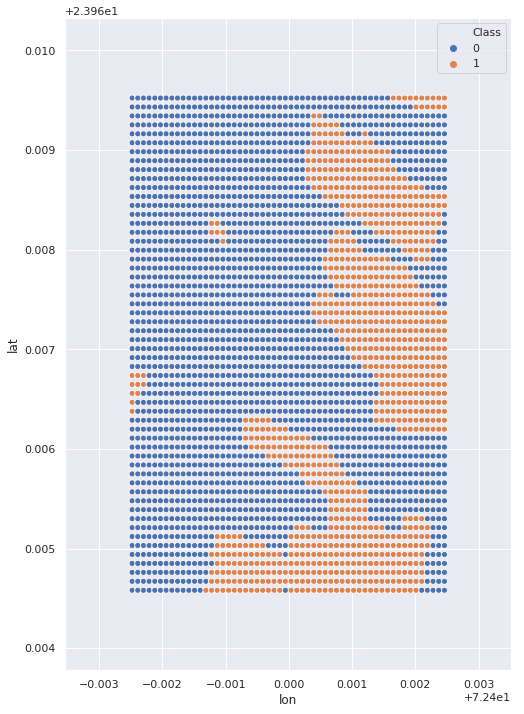

In [23]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 3: LSTM Autoencoder + K-means

Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 1s 593us/step - loss: 0.2266 - val_loss: 0.1608
Epoch 2/50
1568/1568 [==============================] - 0s 282us/step - loss: 0.1484 - val_loss: 0.1313
Epoch 3/50
1568/1568 [==============================] - 0s 269us/step - loss: 0.1377 - val_loss: 0.1289
Epoch 4/50
1568/1568 [==============================] - 0s 260us/step - loss: 0.1355 - val_loss: 0.1282
Epoch 5/50
1568/1568 [==============================] - 0s 267us/step - loss: 0.1331 - val_loss: 0.1259
Epoch 6/50
1568/1568 [==============================] - 0s 261us/step - loss: 0.1308 - val_loss: 0.1242
Epoch 7/50
1568/1568 [==============================] - 0s 258us/step - loss: 0.1291 - val_loss: 0.1228
Epoch 8/50
1568/1568 [==============================] - 0s 258us/step - loss: 0.1272 - val_loss: 0.1214
Epoch 9/50
1568/1568 [==============================] - 0s 261us/step - loss: 0.1249 - val_loss: 0.1200
Epoch 10/50
1568

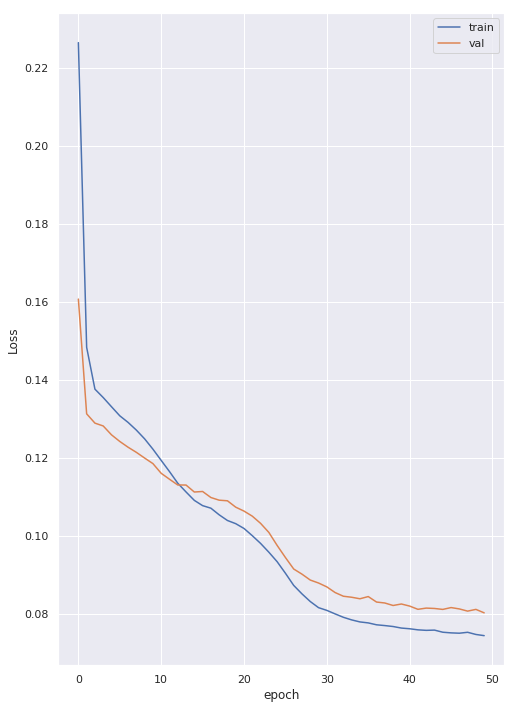

Column 0 has 0.00% of zeros
Column 1 has 0.00% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------
Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 1s 632us/step - loss: 0.2698 - val_loss: 0.2263
Epoch 2/50
1568/1568 [==============================] - 0s 310us/step - loss: 0.2200 - val_loss: 0.1777
Epoch 3/50
1568/1568 [==============================] - 0s 288us/step - loss: 0.1759 - val_loss: 0.1434
Epoch 4/50
1568/1568 [==============================] - 0s 282us/step - loss: 0.1508 - val_loss: 0.1293
Epoch 5/50
1568/1568 [==============================] - 0s 287us/step - loss: 0.1398 - val_loss: 0.1239
Epoch 6/50
1568/1568 [==============================] - 0s 270us/step - loss: 0.1351 - val_loss: 0.1219
Epoch 7/50
1568/1568 [==============================] - 0s 274us/step - loss: 0.1330 - val_loss: 0.1213
Epoch 8/50
1568/1568 [==============================] - 

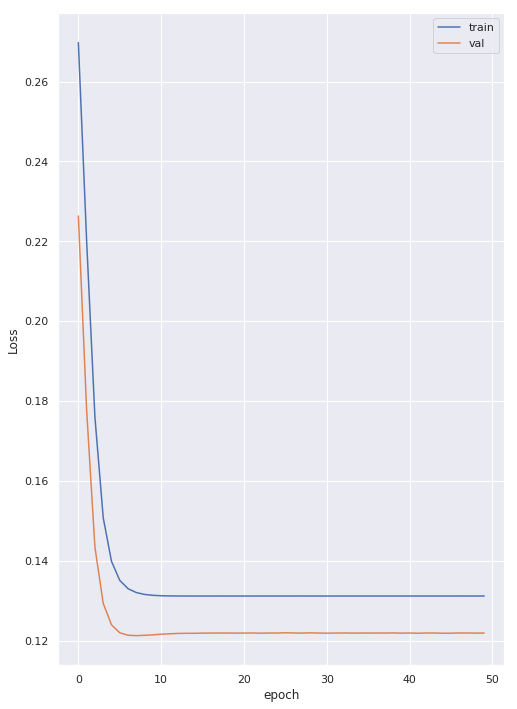

Column 0 has 0.00% of zeros
Column 1 has 100.00% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------
Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 1s 602us/step - loss: 0.1785 - val_loss: 0.1339
Epoch 2/50
1568/1568 [==============================] - 0s 287us/step - loss: 0.1404 - val_loss: 0.1323
Epoch 3/50
1568/1568 [==============================] - 0s 278us/step - loss: 0.1383 - val_loss: 0.1308
Epoch 4/50
1568/1568 [==============================] - 0s 277us/step - loss: 0.1358 - val_loss: 0.1284
Epoch 5/50
1568/1568 [==============================] - 0s 276us/step - loss: 0.1325 - val_loss: 0.1255
Epoch 6/50
1568/1568 [==============================] - 0s 279us/step - loss: 0.1272 - val_loss: 0.1201
Epoch 7/50
1568/1568 [==============================] - 0s 265us/step - loss: 0.1154 - val_loss: 0.1072
Epoch 8/50
1568/1568 [==============================] 

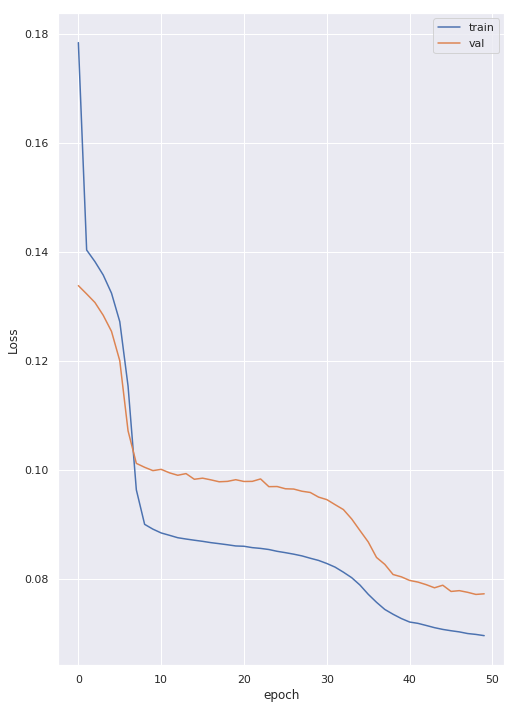

Column 0 has 0.00% of zeros
Column 1 has 0.00% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------
Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 1s 601us/step - loss: 0.2217 - val_loss: 0.1536
Epoch 2/50
1568/1568 [==============================] - 0s 289us/step - loss: 0.1473 - val_loss: 0.1297
Epoch 3/50
1568/1568 [==============================] - 0s 279us/step - loss: 0.1378 - val_loss: 0.1300
Epoch 4/50
1568/1568 [==============================] - 0s 271us/step - loss: 0.1371 - val_loss: 0.1294
Epoch 5/50
1568/1568 [==============================] - 0s 269us/step - loss: 0.1365 - val_loss: 0.1288
Epoch 6/50
1568/1568 [==============================] - 0s 266us/step - loss: 0.1358 - val_loss: 0.1283
Epoch 7/50
1568/1568 [==============================] - 0s 276us/step - loss: 0.1350 - val_loss: 0.1277
Epoch 8/50
1568/1568 [==============================] - 

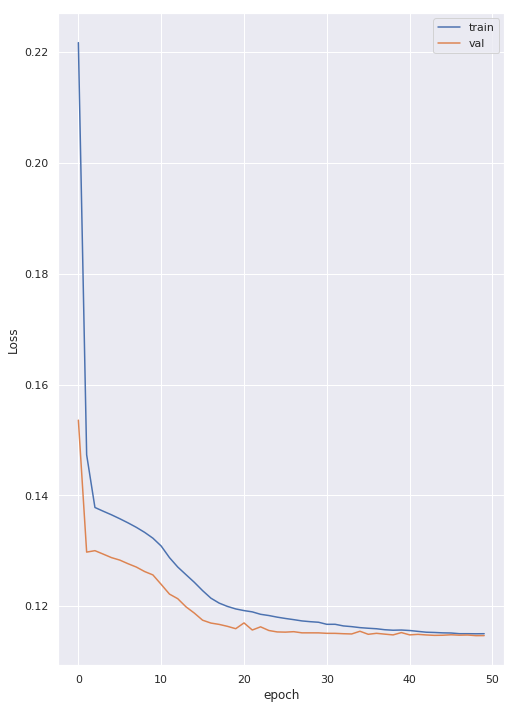

Column 0 has 0.00% of zeros
Column 1 has 0.00% of zeros
Column 2 has 0.00% of zeros


In [24]:
ID_feature = LSTM_autoencoder_plus(in_arr=ID_arr, n_features=3, n_epochs=50)

Silhouette Coefficient is:  0.28800604367947125


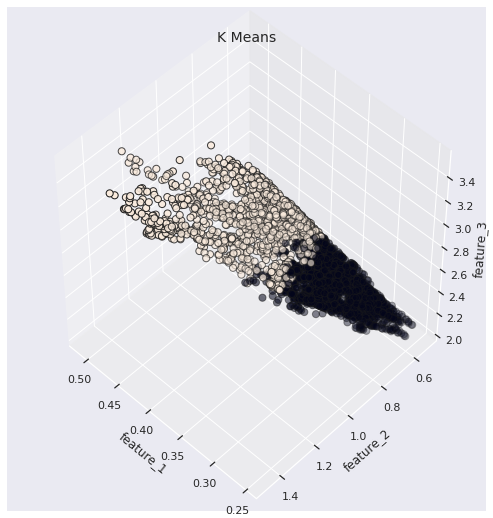

In [25]:
ID_label = kmeans(org_arr=ID_arr, in_arr=ID_feature, n_classes=2)

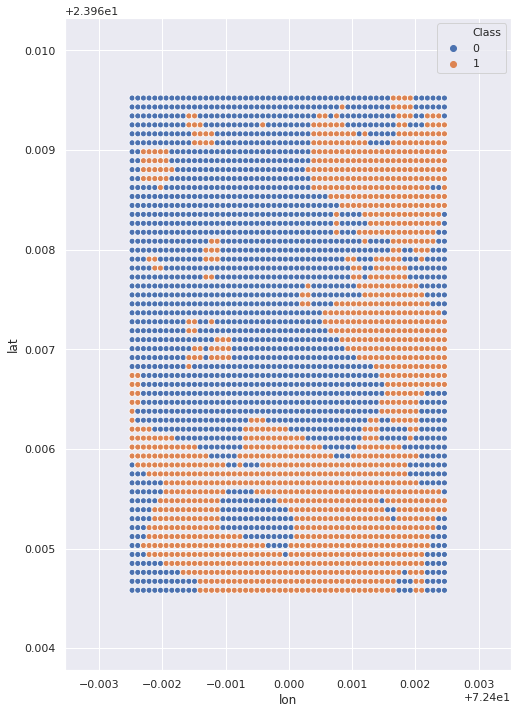

In [26]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 4: LSTM Autoencoder + Agglomerative Clustering

Silhouette Coefficient is:  0.1706978958385657


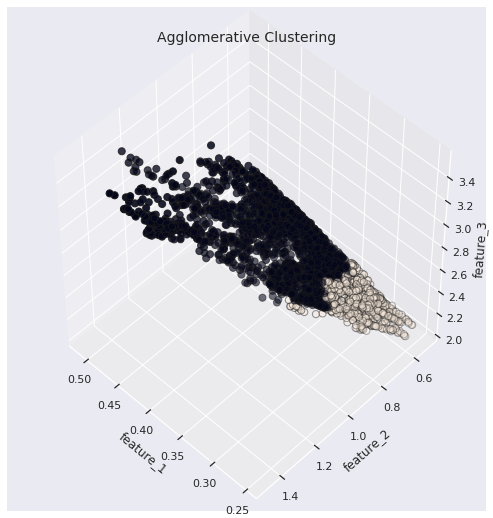

In [27]:
ID_label = agglomerative(org_arr=ID_arr, in_arr=ID_feature, n_classes=2)

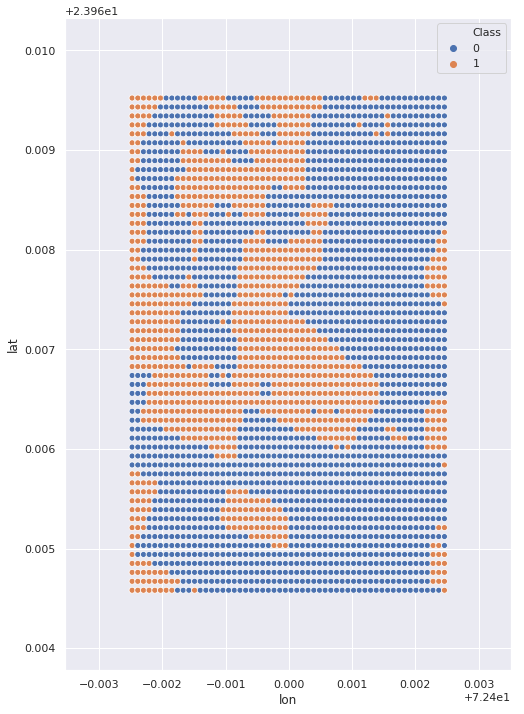

In [28]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')